In [293]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [294]:
suites = ["number_prep", "number_prep2"]

In [295]:
sns.set_context("talk")

## Prediction results

In [296]:
prediction_dfs = [pd.read_csv(f"{suite}.predictions.csv") for suite in suites]
prediction_df = pd.concat(prediction_dfs, names=["suite"], keys=suites)
prediction_df["first_item"] = prediction_df.used_item_numbers.str.split().str.get(0)
prediction_df

item_number  prediction_0 used_item_numbers  \
suite                                                            
number_prep  0               1          True                 1   
             1               2          True                 2   
             2               3         False                 3   
             3               4          True                 4   
             4               5         False                 5   
...                        ...           ...               ...   
number_prep2 5006         8021         False    7 1 14 18 5 15   
             5007         8022         False    7 1 14 18 5 16   
             5008         8023         False    7 1 14 18 5 19   
             5009         8024         False    7 1 14 18 10 3   
             5010         8025         False    7 1 14 18 10 6   

                                                     used_conditions  \
suite                                                                  
number_prep  0                                                   NaN   
             1                                                   NaN   
             2                                                   NaN   
             3                                                   NaN   
             4                                                   NaN   
...                                                              ...   
number_prep2 5006   match_sing match_sing match_sing match_sing m...   
             5007   match_sing match_sing match_sing match_sing m...   
             5008   match_sing match_sing match_sing match_sing m...   
             5009   match_sing match_sing match_sing match_sing m...   
             5010   match_sing match_sing match_sing match_sing m...   

                   prefix_length first_item  
suite                                        
number_prep  0                 0          1  
             1                 0          2  
             2                 0          3  
             3                 0          4  
             4                 0          5  
...                          ...        ...  
number_prep2 5006             45          7  
             5007             43          7  
             5008             44          7  
             5009             41          7  
             5010             41          7  

[7522 rows x 6 columns]

In [297]:
prediction_df[prediction_df.used_conditions.isna()].prediction_0.mean()

0.7894736842105263

<AxesSubplot:ylabel='Frequency'>

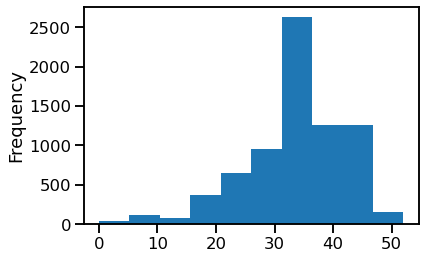

In [298]:
prediction_df.prefix_length.plot.hist()

Text(0, 0.5, 'Prediction accuracy')

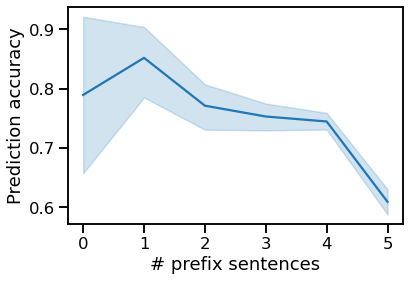

In [310]:
prediction_df["num_prefix_sentences"] = prediction_df.used_conditions.str.count(" ").fillna(0)
sns.lineplot(data=prediction_df, x="num_prefix_sentences", y="prediction_0")

plt.xlabel("# prefix sentences")
plt.ylabel("Prediction accuracy")

Text(0, 0.5, 'Prediction accuracy')

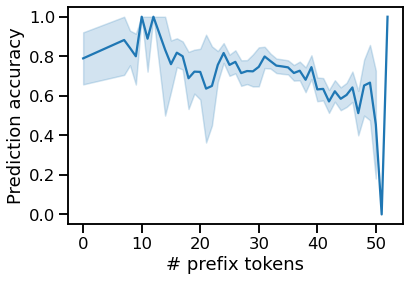

In [312]:
sns.lineplot(data=prediction_df, x="prefix_length", y="prediction_0")

plt.xlabel("# prefix tokens")
plt.ylabel("Prediction accuracy")

Text(0, 0.5, 'Prediction accuracy')

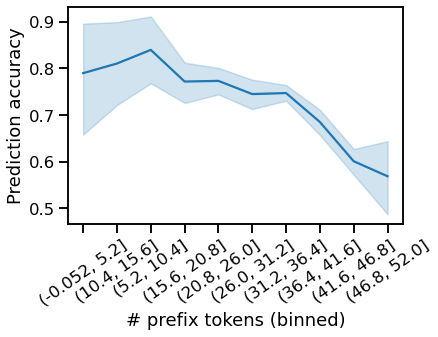

In [313]:
prediction_df["prefix_length_bin"] = pd.cut(prediction_df.prefix_length, 10).astype(str)
sns.lineplot(data=prediction_df, x="prefix_length_bin", y="prediction_0")
plt.xticks(rotation=35)

plt.xlabel("# prefix tokens (binned)")
plt.ylabel("Prediction accuracy")

## Margins

In [302]:
region_dfs = [pd.read_csv(f"{suite}.regions.csv") for suite in suites]
region_df = pd.concat(region_dfs, names=["suite"], keys=suites)
region_df

item_number      value        condition  region_number
suite                                                                      
number_prep  0                 1  12.441166       match_sing              2
             1                 2  14.024705       match_sing              2
             2                 3  13.151198       match_sing              2
             3                 4  15.575526       match_sing              2
             4                 5  13.095509       match_sing              2
...                          ...        ...              ...            ...
number_prep2 160347         8021   1.038817  mismatch_plural              8
             160348         8022   0.977829  mismatch_plural              8
             160349         8023   0.589392  mismatch_plural              8
             160350         8024   0.556063  mismatch_plural              8
             160351         8025   0.433245  mismatch_plural              8

[240704 rows x 4 columns]

In [303]:
# Bring in metadata from predictions df
region_df = pd.merge(region_df.reset_index(), prediction_df[["item_number", "prefix_length", "first_item", "num_prefix_sentences"]].reset_index(),
                     on=["suite", "item_number"])
len(region_df)

240832

Text(0, 0.5, 'Raw surprisal')

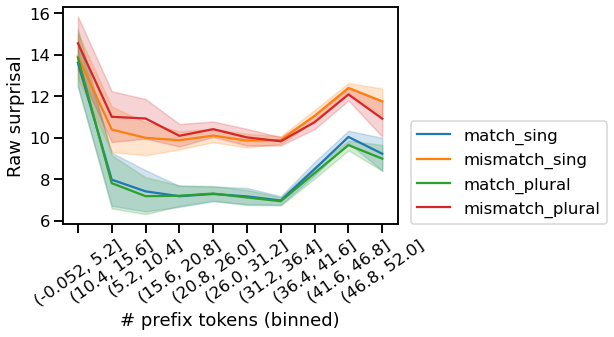

In [315]:
region_df["prefix_length_bin"] = pd.cut(region_df.prefix_length, 10).astype(str)
sns.lineplot(data=region_df[region_df.region_number == 7], x="prefix_length_bin", y="value", hue="condition")

plt.xticks(rotation=35)
plt.legend(loc=(1.04,0))
plt.xlabel("# prefix tokens (binned)")
plt.ylabel("Raw surprisal")

Text(0, 0.5, 'Raw surprisal')

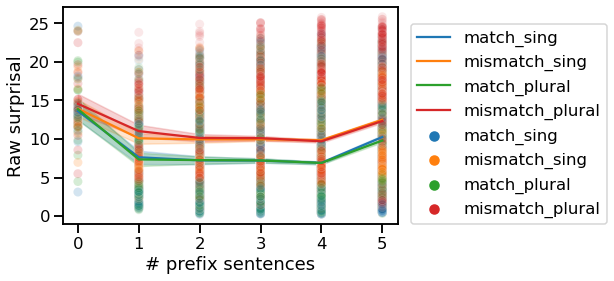

In [326]:
sns.lineplot(data=region_df[region_df.region_number == 7], x="num_prefix_sentences", y="value", hue="condition")
sns.scatterplot(data=region_df[region_df.region_number == 7], x="num_prefix_sentences", y="value", hue="condition", alpha=0.1)

plt.legend(loc=(1.04,0))
plt.xlabel("# prefix sentences")
plt.ylabel("Raw surprisal")

In [306]:
def compute_margins(item_rows):
    item_rows = item_rows.pivot_table(values="value", index="condition", columns="region_number")
    return pd.Series({"sing": item_rows.loc["mismatch_sing", 7] - item_rows.loc["match_sing", 7],
                      "plur": item_rows.loc["mismatch_plural", 7] - item_rows.loc["match_plural", 7]})

margin_sizes = region_df.groupby("item_number").apply(compute_margins)

In [307]:
margin_sizes = pd.merge(margin_sizes, prediction_df[["item_number", "prefix_length", "first_item"]],
                        on="item_number")
margin_sizes

,item_number,sing,plur,prefix_length,first_item
0,1,-0.850466,1.665415,0,1
1,1,-0.850466,1.665415,0,1
2,2,-0.512165,-0.062262,0,2
3,2,-0.512165,-0.062262,0,2
4,3,1.939454,0.672040,0,3
...,...,...,...,...,...
7517,8021,6.357800,-2.053082,45,7
7518,8022,6.206444,-2.320858,43,7
7519,8023,6.386032,-3.685282,44,7
7520,8024,6.673686,-0.779233,41,7


Text(0, 0.5, 'Grammaticality margin (bits)')

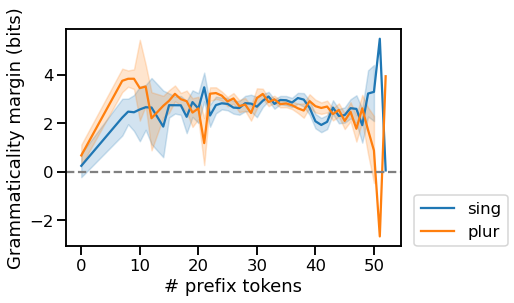

In [319]:
sns.lineplot(data=margin_sizes.melt(id_vars=["prefix_length"], value_vars=["sing", "plur"], var_name="Prediction"),
             x="prefix_length", y="value", hue="Prediction")

plt.legend(loc=(1.04, 0))
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("# prefix tokens")
plt.ylabel("Grammaticality margin (bits)")

Text(0, 0.5, 'Grammaticality margin (bits)')

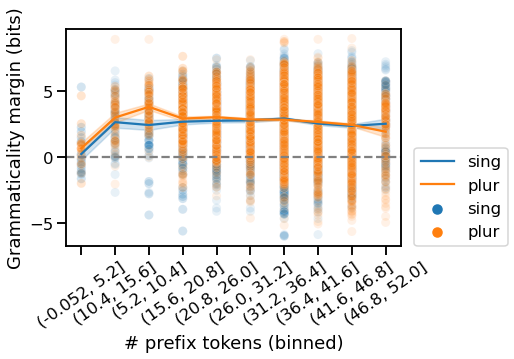

In [324]:
margin_sizes["prefix_length_bin"] = pd.cut(margin_sizes.prefix_length, 10).astype(str)
sns.lineplot(data=margin_sizes.melt(id_vars=["prefix_length_bin"], value_vars=["sing", "plur"], var_name="Prediction"),
             x="prefix_length_bin", y="value", hue="Prediction")
sns.scatterplot(data=margin_sizes.melt(id_vars=["prefix_length_bin"], value_vars=["sing", "plur"], var_name="Prediction"),
                x="prefix_length_bin", y="value", hue="Prediction", alpha=0.1)

plt.legend(loc=(1.04, 0))
plt.axhline(0, color="gray", linestyle="--")
plt.xticks(rotation=35)
plt.xlabel("# prefix tokens (binned)")
plt.ylabel("Grammaticality margin (bits)")